# Early Warning System

The proposed Early Warning System for Food Security done by the SMU Team consists of 3 main notebooks

1. [Article Classification Model](./Article%Classification%20Model.ipynb)
2. [Risk Scoring and Fine Tuning](./Risk%20Scoring%20and%20Fine%20tuning%20(Final).ipynb)
3. [Report Generator](./Report%20Generator.ipynb)

In these python notebook, we will be documenting our project codes for our industry sponsor, Food Security Exchange (FSX). This will be written in python, with supplementary comments at each step to ensure that users can both comprehend and trust the results and output generated by the algorithms.

Our project mines trigger events related news articles from various sources, before classifying them according to predefined supply chain disruption categories using both a rule-based and ML-based approach. Following this, a predictive risk score is assigned to every article.


The general flow of how the Early Warning System will work is as follows:

1. Identify article to be classified and load it into the first notebook
    - Subsequently, the first notebook will output a csv file containing the trigger event classified with the article that is being loaded in
3. Load the outputted csv into the second notebook
    - The second notebook will process and score the article against a predefined risk scoring framework
    - Fine tuning of the scores will commence in the second notebook after the initial scoring
    - A csv will be ouputted from the second notebook containing all the risk scores
7. Load the csv into the report generator
    - A report will be created


# Overview of Notebook



This notebook is split into 3 sections
- Importing of libraries
- Feature extraction/ splitting of training dataset
- Processing the article(s) data and classifying it based on trigger event

Outputs:
- CSV file named "initial_article.csv" with columns: 
    - link
    - content summary
    - Preprocessed Text
    - Preprocessed Text 2
    - trigger event


## Importing of Libraries

In [2]:
# Import libraries

import pandas as pd
import re 

import nltk 
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost 
from sklearn.metrics  import classification_report
from sklearn import metrics
import time


## Reading Training Dataset

In [3]:
df = pd.read_csv("Consolidated_News_Articles_With_Sentiment_Labels.csv")

## Feature Extraction And Splitting of The Training Dataset To Load Data Into The Model

In [4]:
def preprocess(text):
    
    """
    Function: split text into words and return the root form of the words
    Args:
      text(str): the article
    Return:
      lem(list of str): a list of the root form of the article words
    """
        
    # Normalize text
    text = re.sub(r"[^a-zA-Z]", " ", str(text).lower())
    
    # Tokenize text
    token = word_tokenize(text)
    
    # Remove stop words
    stop = stopwords.words("english")
    new_stop_words_list = ['said', 'us', 'also', 'mr']
    stop.extend(new_stop_words_list)
    words = [t for t in token if t not in stop]
    
    # Lemmatization
    lem = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return lem

df["Preprocessed_Text"] = df['content summary'].apply(lambda x: preprocess(x))

df['Preprocessed_Text2'] = df['Preprocessed_Text'].apply(' '.join)

X = df['Preprocessed_Text2']
y = df['trigger event']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

tf_vec = TfidfVectorizer()
train_features = tf_vec.fit(X_train)
train_features = tf_vec.transform(X_train)
test_features = tf_vec.transform(X_test)
train_features

<10997x34861 sparse matrix of type '<class 'numpy.float64'>'
	with 632921 stored elements in Compressed Sparse Row format>

In [5]:
df.head()

,date,location,news title,news source(url),content summary,keywords,scrapped terms,trigger event,Preprocessed_Text,Preprocessed_Text2,sentiment score,compound score,sentiment label
0,Feb-22,MUMBAI (REUTERS),Himalayan avalanche kills seven Indian soldier...,https://www.straitstimes.com/asia/himalayan-av...,MUMBAI (REUTERS) - A Himalayan avalanche kille...,"kills, avalanche, defence, kameng, china, sold...",natural calamities,geophysical event,"[mumbai, reuters, himalayan, avalanche, killed...",mumbai reuters himalayan avalanche killed seve...,"{'neg': 0.148, 'neu': 0.773, 'pos': 0.079, 'co...",-0.7506,negative
1,Feb-22,ZURICH (REUTERS),Eight killed in two days after third deadly av...,https://www.straitstimes.com/world/europe/eigh...,ZURICH (REUTERS) - One person was killed and f...,"person, avalanche, tyrol, killed, days, skiers...",natural calamities,geophysical event,"[zurich, reuters, one, person, killed, four, o...",zurich reuters one person killed four others i...,"{'neg': 0.276, 'neu': 0.63, 'pos': 0.094, 'com...",-0.9665,negative
2,Feb-22,VIENNA (REUTERS),Avalanche in Austria near Swiss border kills five,https://www.straitstimes.com/world/europe/aval...,VIENNA (REUTERS) - An avalanche in an area of ...,"kills, avalanche, person, services, supervisor...",natural calamities,geophysical event,"[vienna, reuters, avalanche, area, austria, bo...",vienna reuters avalanche area austria borderin...,"{'neg': 0.258, 'neu': 0.607, 'pos': 0.135, 'co...",-0.9100,negative
3,Feb-22,NEW DELHI (REUTERS),Himalayan avalanche traps Indian Army patrol t...,https://www.straitstimes.com/asia/south-asia/h...,NEW DELHI (REUTERS) - A Himalayan avalanche tr...,"arunachal, avalanche, army, defence, team, chi...",natural calamities,geophysical event,"[new, delhi, reuters, himalayan, avalanche, tr...",new delhi reuters himalayan avalanche trapped ...,"{'neg': 0.045, 'neu': 0.782, 'pos': 0.172, 'co...",0.8225,positive
4,Feb-21,SALT LAKE CITY (NYTIMES),"4 skiers killed in avalanche in Utah, official...",https://www.straitstimes.com/world/united-stat...,SALT LAKE CITY (NYTIMES) - Four back-country s...,"avalanche, states, killed, skiers, saidthe, sa...",natural calamities,geophysical event,"[salt, lake, city, nytimes, four, back, countr...",salt lake city nytimes four back country skier...,"{'neg': 0.258, 'neu': 0.703, 'pos': 0.039, 'co...",-0.9509,negative


## Loading The Trained Gradient Boosting Model

- For more details, refer to the "FYP Classification Codes Notebook" for more details as to how this model is derived and trained

In [6]:
import pickle
file_name = "gb_reg.pkl"
gb = pickle.load(open(file_name, "rb"))

## Defining a Function to Classify The Article

- A threshold value of 0.56 is used in the below function to determine if an event (i.e. the input) is related and therefore should be classified as a trigger event. Specific methodology in deriving the threshold value can be found in the [here](../../News%20Classifier/Derivation%20of%20Threshold%20Value.ipynb).

In [7]:
def classify_article(path):
    
    """
    Function: classify an article.
    Args:
      path: the path of the article 
    Return:
      category (str): the category of the article
    """
    # Read file
    file = open(path, 'r')
    artcl = file.read()

    # Text preprocessing
    artcl = preprocess(artcl)
    artcl = ' '.join(artcl)

    # Use TF_IDF
    test = tf_vec.transform([artcl])

    # Use GradientBoosting model to classify the article
    predict = gb.predict(test)
    predict_score = gb.predict_proba(test)
    sorted_predict_score = sorted(predict_score.tolist()[0], reverse=True)
    if (sorted_predict_score[0] < 0.56) :
        category = "Not related"
    else:
        category = predict[0]

    # Close file
    file.close()

    return category, predict_score[0]

## Classifying Article

In [8]:
new_category = ["Acute climatological event (cyclone)", "Acute climatological event (droughts)", "Acute climatological event (flood)", "Acute climatological event (heat stress)", "Economic Crisis", "Man-Made Disaster",
                "Military Conflicts", "Terrorism" , "Trade Dispute", "cyberattack", "geophysical event", "idiosyncratic", "pandemic"]


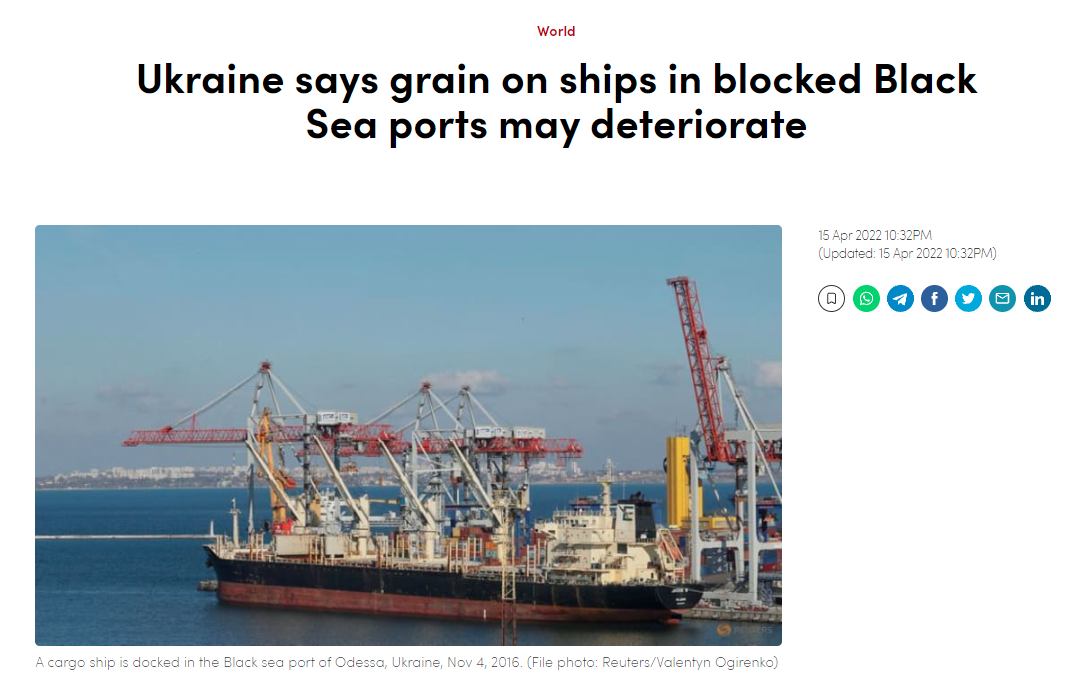

- https://www.channelnewsasia.com/world/ukraine-invasion-russia-ships-grain-black-sea-ports-2628556

In [8]:
link = 'https://www.channelnewsasia.com/world/ukraine-invasion-russia-ships-grain-black-sea-ports-2628556'

In [9]:
from newspaper import Article

article = Article(link)


article.download()

article.parse()

article.nlp()

print(article.summary)

with open('art3.txt', 'w') as f:
    f.write(article.summary)
    
print(" ")
print("Classified Article Category: " + classify_article('art3.txt')[0])

probability_array = classify_article('art3.txt')[1]

# print(probability_array[0])

df = pd.DataFrame(data=probability_array * 100, index=new_category , columns=["Probability"])

df



Ukraine used to export almost all its grain and oilseeds via seaports and now is forced to find new routes as its ports are blocked.
Before the war, Ukraine exported up to 6 million tonnes of grain and oilseed a month, while in March the exports fell to 200,000 tonnes, Mykola Solskyi told the newspaper Ukrayinska Pravda.
There are currently 57 vessels with 1.25 million tonnes of grain and oilseeds," Solskyi said.
They certainly did not plan to keep this grain on the ships for a long time," he added.
He said importers were already spending more and the situation with grain supply from Ukraine could push these countries to build greater grain reserves and this would also drive up prices.
 
Classified Article Category: Military Conflicts


,Probability
Acute climatological event (cyclone),2.462861
Acute climatological event (droughts),6.824881
Acute climatological event (flood),2.542745
Acute climatological event (heat stress),3.355018
Economic Crisis,2.859606
Man-Made Disaster,4.246906
Military Conflicts,61.427700
Terrorism,1.133210
Trade Dispute,1.663355
cyberattack,0.712971


In [16]:
article.title

'Ukraine says grain on ships in blocked Black Sea ports may deteriorate'

# Creating CSV Output

In [29]:
output_data = {'Article Link': [link], 'content summary': [article.summary], 'news title': [article.title], 'date': [article.publish_date]}
output_df = pd.DataFrame(output_data)

In [30]:
output_df["Preprocessed_Text"] = output_df['content summary'].apply(lambda x: preprocess(x))

output_df['Preprocessed_Text2'] = output_df['Preprocessed_Text'].apply(' '.join)

In [31]:
output_df["trigger event"] = classify_article('art3.txt')[0]

In [32]:
output_df.head()

,Article Link,content summary,news title,date,Preprocessed_Text,Preprocessed_Text2,trigger event
0,https://www.channelnewsasia.com/world/ukraine-...,Ukraine used to export almost all its grain an...,Ukraine says grain on ships in blocked Black S...,None,"[ukraine, used, export, almost, grain, oilseed...",ukraine used export almost grain oilseed via s...,Military Conflicts


In [33]:
output_df.to_csv("initial_article.csv")

# End of First Notebook

Proceed on to the second notebook: [Risk Scoring and Fine Tuning](./Risk%20Scoring%20and%20Fine%20tuning%20(Final).ipynb)

# References

In [10]:
from newspaper import Article

article = Article('https://www.channelnewsasia.com/business/brazil-meat-cargos-shanghai-port-disrupted-amid-indefinite-lockdown-2627486')


article.download()

article.parse()

article.nlp()

print(article.summary)

with open('art5.txt', 'w') as f:
    f.write(article.summary)
    
print(" ")
print("Classified Article Category: " + classify_article('art5.txt')[0])

probability_array = classify_article('art5.txt')[1]

# print(probability_array[0])

df = pd.DataFrame(data=probability_array * 100, index=new_category , columns=["Probability"])

df



At least one shipping line operator has stopped sending Brazilian meat to Shanghai, the source said, instead offering clients the alternative of sending cargos to Xingang and Ningbo.
One big Brazilian meat exporter canceled the shipment of three containers, while another stopped booking new cargo, the source added.
Shanghai is the main point of entry for Brazilian meat imports to mainland China, which is Brazil's top trade partner.
China imported 723,370 tonnes of beef and 640,469 tonnes of chicken from Brazil in 2021, according to industry data, the largest consumer of Brazilian meat by far.
It is unclear how much cargo is being affected by Shanghai's lockdown and restrictions on new cargo bookings to Russia.
 
Classified Article Category: Not related


,Probability
Acute climatological event (cyclone),5.645899
Acute climatological event (droughts),13.753670
Acute climatological event (flood),5.829027
Acute climatological event (heat stress),7.691093
Economic Crisis,6.555403
Man-Made Disaster,2.358190
Military Conflicts,6.292983
Terrorism,2.597787
Trade Dispute,9.420838
cyberattack,1.634424


In [12]:
from newspaper import Article

article = Article('https://www.channelnewsasia.com/asia/japan-shanghai-consul-airs-concerns-virus-covid-19-curbs-2629471')


article.download()

article.parse()

article.nlp()

print(article.text)

with open('art2.txt', 'w') as f:
    f.write(article.text)
    
print(" ")
print("Classified Article Category: " + classify_article('art2.txt')[0])

probability_array = classify_article('art2.txt')[1]

# print(probability_array[0])

df = pd.DataFrame(data=probability_array * 100, index=new_category , columns=["Probability"])

df



SHANGHAI: Japan's top representative in Shanghai urged China's most populous city to address concerns of Japanese businesses over losses and other disruptions caused by lockdowns aimed at containing a COVID-19 surge.

Consul general Shuichi Akamatsu's letter, posted on the consulate's website on Saturday (Apr 16), comes as most of Shanghai's 25 million residents remain under strict lockdowns that have hobbled economic activity in the financial centre. The city reported a record 3,590 symptomatic cases on Saturday.

The US State Department on Monday ordered non-emergency US government workers to leave the consulate due to surging virus numbers and China's measures to control its spread.

The Shanghai government did not immediately respond to questions from Reuters on Saturday. China's foreign ministry has termed the State Department concerns over coronavirus control measures in Shanghai "groundless accusations".

Akamatsu acknowledged the city's efforts at curbing the spread of the coro

,Probability
Acute climatological event (cyclone),3.074991
Acute climatological event (droughts),8.521165
Acute climatological event (flood),3.174730
Acute climatological event (heat stress),4.188888
Economic Crisis,48.245034
Man-Made Disaster,1.176297
Military Conflicts,3.427419
Terrorism,1.414862
Trade Dispute,2.076772
cyberattack,0.890175
